In [1]:
import pandas as pd
# Maksimal sütun sayını göstərmək üçün konfiqurasiya
pd.set_option('display.max_columns', None)
# Float formatını göstərmək üçün konfiqurasiya
pd.set_option('display.float_format', lambda x: '%.2f' % x)

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from mlxtend.regressor import StackingCVRegressor
from scipy import stats
from sklearn import metrics
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
import optuna
import joblib

# Xəbərdarlıqları söndürmək
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Faylı oxumaq
df = pd.read_csv('turbo_az_150724.csv')

In [3]:
# İlk 5 sətirə baxmaq
df.head()

,type,name,brand,model,year,engine (l),run (km),price
0,Car,Kia Sportage,Kia,Sportage,2015,1.70,158000,30430.00
1,Car,Kia Ceed,Kia,Ceed,2013,1.40,210000,16500.00
2,Car,Kia Sorento,Kia,Sorento,2013,2.00,135000,30200.00
3,Car,Changan Uni-T,Changan,Uni-T,2021,1.50,40000,32000.00
4,Car,Lexus IS 250,Lexus,IS 250,2010,2.50,132000,25500.00


In [4]:
# Dataset barədə məlumatlara baxmaq
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9691 entries, 0 to 9690
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   type        9691 non-null   object 
 1   name        9691 non-null   object 
 2   brand       9691 non-null   object 
 3   model       9691 non-null   object 
 4   year        9691 non-null   int64  
 5   engine (l)  9691 non-null   float64
 6   run (km)    9691 non-null   int64  
 7   price       9691 non-null   float64
dtypes: float64(2), int64(2), object(4)
memory usage: 605.8+ KB


In [5]:
# Təkrarlanan sətirlərin sayına baxmaq
df.duplicated().sum()

0

In [6]:
# Numerik sütunların statistik dəyərlərinə baxmaq
df.describe().T

,count,mean,std,min,25%,50%,75%,max
year,9691.00,2011.73,8.39,1955.00,2007.00,2013.00,2017.00,2024.00
engine (l),9691.00,2.26,1.34,0.00,1.60,2.00,2.50,19.00
run (km),9691.00,175417.14,166680.93,0.00,75000.00,158000.00,241000.00,8000000.00
price,9691.00,37692.64,47368.56,530.00,12900.00,24500.00,43000.00,699550.00


<Axes: ylabel='brand'>

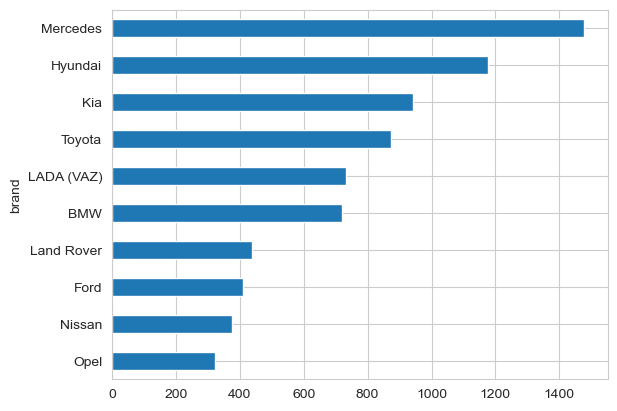

In [7]:
# Hansı brendlər ən çox satışa qoyulub
df['brand'].value_counts().nlargest(10).sort_values(ascending=True).plot(kind='barh')

<Axes: ylabel='name'>

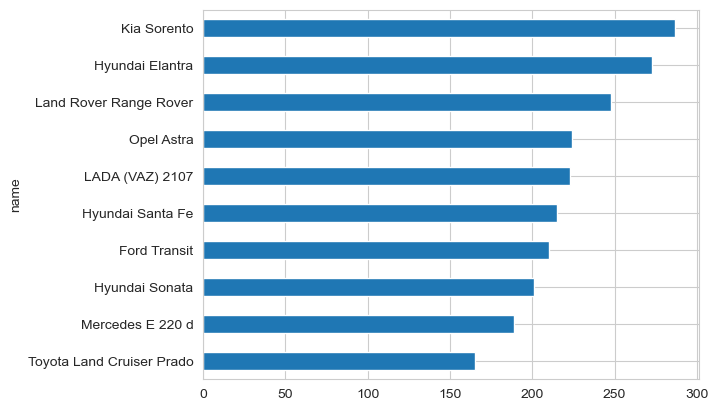

In [8]:
# Hansı maşınlar ən çox satışa qoyulub
df['name'].value_counts().nlargest(10).sort_values(ascending=True).plot(kind='barh')

<Axes: ylabel='year'>

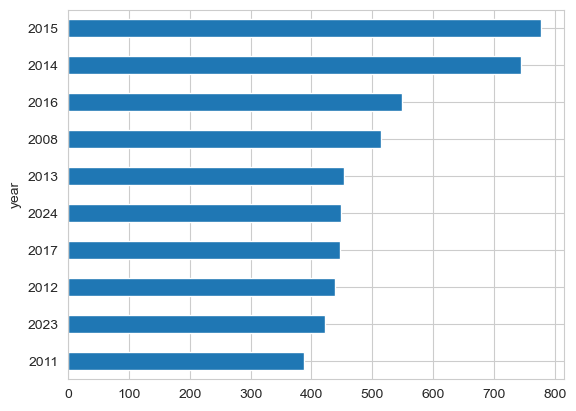

In [9]:
# Hansı ilə aid maşınlar ən çox satışa qoyulub
df['year'].value_counts().nlargest(10).sort_values(ascending=True).plot(kind='barh')

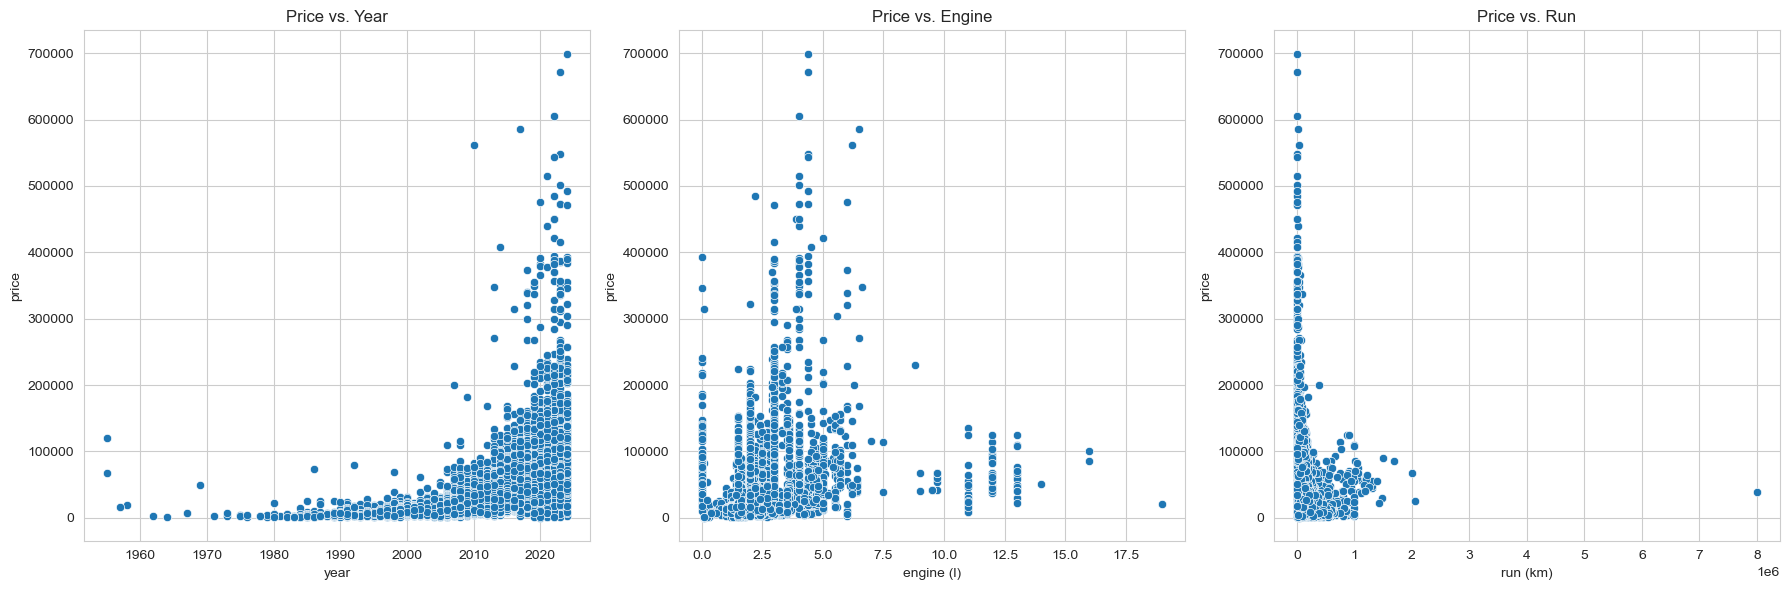

In [10]:
# Sütun və başlıqları təyin etmək
plot_cols = {
    'year': 'Price vs. Year',
    'engine (l)': 'Price vs. Engine',
    'run (km)': 'Price vs. Run'
}

# Fiqur yaratmaq
plt.figure(figsize=(18, 6))

# Sütunlar və başlıqlar arasında dövr etdirmək
for i, (x_col, title) in enumerate(plot_cols.items(), 1):
    plt.subplot(1, 3, i)
    sns.scatterplot(data=df, x=x_col, y='price')
    plt.title(title)

plt.tight_layout()
plt.show()

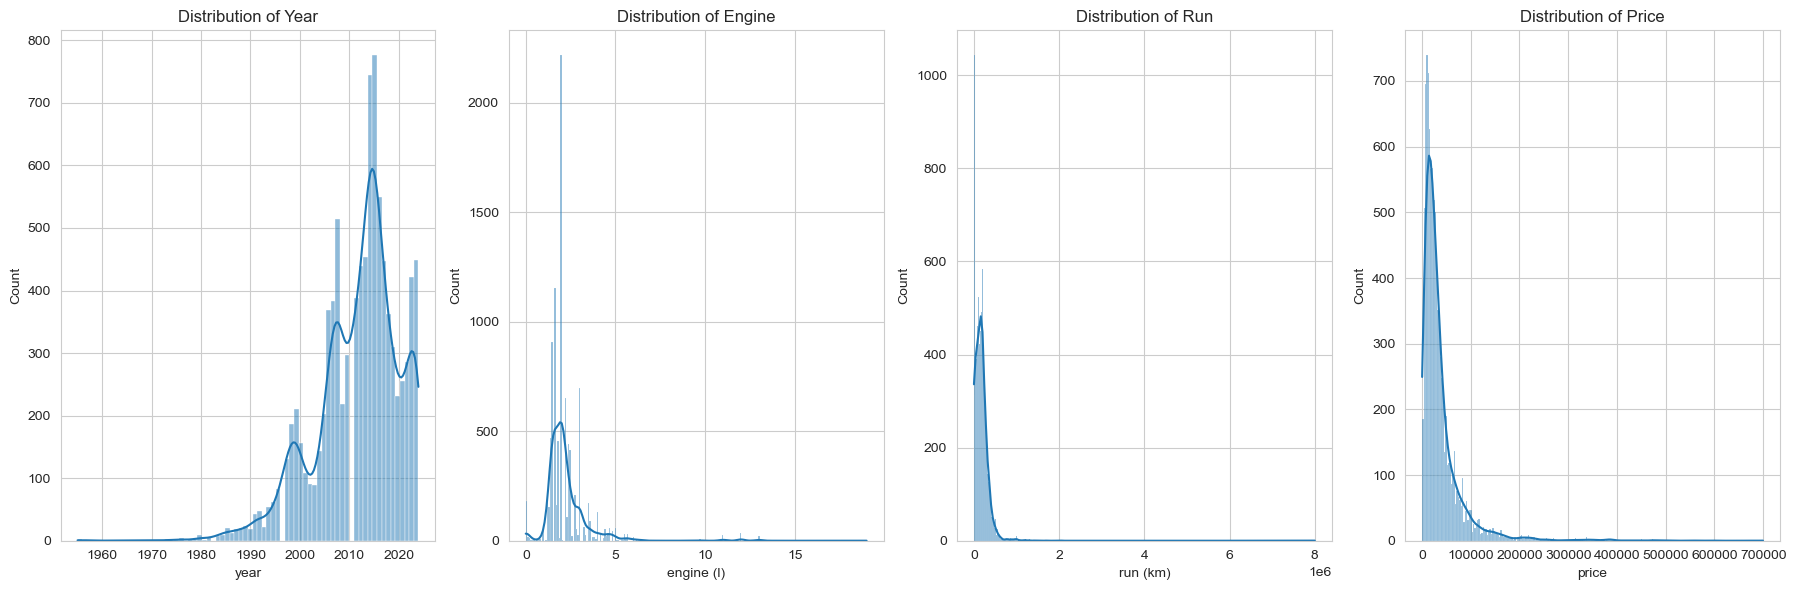

In [11]:
# Sütun və başlıqları təyin etmək
plot_columns = {
    'year': 'Distribution of Year',
    'engine (l)': 'Distribution of Engine',
    'run (km)': 'Distribution of Run',
    'price': 'Distribution of Price'
}

# Fiqur yaratmaq
plt.figure(figsize=(18, 6))

# Sütunlar və başlıqlar arasında dövr etdirmək
for i, (x_col, title) in enumerate(plot_columns.items(), 1):
    plt.subplot(1, 4, i)
    sns.histplot(data=df, x=x_col, kde=True)
    plt.title(title)


plt.tight_layout()
plt.show()

In [12]:
# Brand və Model əlaqələrini yaratmaq
df_brands = df[['type', 'brand', 'model', 'engine (l)']].drop_duplicates().sort_values(by=['type', 'brand', 'model', 'engine (l)']).\
                                                                                                            reset_index(drop=True)

# Brand və Model əlaqələrini saxlamaq
joblib.dump(df_brands, 'brands.pkl')

['brands.pkl']

In [13]:
# LabelEncoder obyektini yaratmaq
label_encoder_brand = LabelEncoder()
label_encoder_model = LabelEncoder()

# 'brand' sütununu kodlaşdırmaq
df['brand_encoded'] = label_encoder_brand.fit_transform(df['brand'])

# 'model' sütununu kodlaşdırmaq
df['model_encoded'] = label_encoder_model.fit_transform(df['model'])

# Seçilmiş sütunları silmək
df.drop(['type', 'name', 'brand', 'model'], axis=1, inplace=True)

# 'type' sütununu one-hot encoding formatına çevirmək
# df = pd.get_dummies(df, columns=['type'], drop_first=False).astype('int64')

# LabelEncoder obyektlərini və kodlaşdırılmış type sütunlarını saxlayın
joblib.dump(label_encoder_brand, 'encoded_brand.pkl')
joblib.dump(label_encoder_model, 'encoded_model.pkl')
# type_cols = [col for col in df.columns if col.startswith('type_')]
# joblib.dump(type_cols, 'encoded_type.pkl')

['encoded_model.pkl']

In [14]:
# Müstəqil dəyişənlər və asılı dəyişəni təyin etmək
inputs = df.drop('price', axis=1)
target = df['price']

X_train, X_test, y_train, y_test = train_test_split(inputs, target, test_size=0.3, random_state=42)

In [15]:
# Base Modellər üçün pipeline yaradırıq
models = []

rf_base = RandomForestRegressor()
xgb_base = XGBRegressor()
lgbm_base = LGBMRegressor()
cat_base = CatBoostRegressor()

models.extend([
    ('RandomForest', rf_base),
    ('XGBoost', xgb_base),
    ('LightGBM', lgbm_base),
    ('CatBoost', cat_base)
])

In [16]:
# Train və Test üzrə R2 hesablamaq üçün funksiya yaratmaq
def train_and_evaluate_model(model_name, model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    
    mae_train = metrics.mean_absolute_error(y_train, y_pred_train)
    mse_train = metrics.mean_squared_error(y_train, y_pred_train)
    rmse_train = np.sqrt(mse_train)
    r2_train = metrics.r2_score(y_train, y_pred_train)
    
    mae_test = metrics.mean_absolute_error(y_test, y_pred_test)
    mse_test = metrics.mean_squared_error(y_test, y_pred_test)
    rmse_test = np.sqrt(mse_test)
    r2_test = metrics.r2_score(y_test, y_pred_test)

    print(f'Model Performance for {model_name}:')
    print('Train R2:', r2_train*100)
    print('Test R2:', r2_test*100)
    
    return r2_train, r2_test

In [17]:
# For loop-u və if, else şərtlərindən istifadə edərək base modellər üzrə R2 hesablayıb dataframe şəklində yadda saxlayırıq
r2_results = pd.DataFrame(columns=['Model', 'Train R2', 'Test R2'])

for model_name, model in models:
    r2_train, r2_test = train_and_evaluate_model(model_name, model, X_train, y_train, X_test, y_test)
        
    if r2_train is not None and r2_test is not None:
        r2_results = pd.concat([r2_results, pd.DataFrame({'Model': [model_name], 'Train R2': [r2_train * 100], 'Test R2': [r2_test * 100]})], 
                          ignore_index=True)
        
r2_results = r2_results.sort_values(by=['Train R2', 'Test R2'], ascending=False)

Model Performance for RandomForest:
Train R2: 97.56218555679558
Test R2: 89.54440622097499
Model Performance for XGBoost:
Train R2: 98.84128609209395
Test R2: 90.79889566543442
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000129 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 706
[LightGBM] [Info] Number of data points in the train set: 6783, number of used features: 5
[LightGBM] [Info] Start training from score 37779.226519
Model Performance for LightGBM:
Train R2: 93.12873732537817
Test R2: 91.08479823456314
Learning rate set to 0.055404
0:	learn: 46555.8862476	total: 149ms	remaining: 2m 28s
1:	learn: 45076.6370797	total: 152ms	remaining: 1m 15s
2:	learn: 43683.4318959	total: 154ms	remaining: 51.3s
3:	learn: 42275.3995973	total: 158ms	remaining: 39.2s
4:	learn: 40969.4762288	total: 161ms	remaining: 32.1s
5:	learn: 3

In [18]:
# Base modellər üzrə R2 nəticələrinə baxış
r2_results

,Model,Train R2,Test R2
1,XGBoost,98.84,90.80
0,RandomForest,97.56,89.54
3,CatBoost,96.51,91.42
2,LightGBM,93.13,91.08


In [19]:
# Stacking Regressor modelinin qurulması
# Meta olaraq test üzrə ən yaxşı nəticə göstərən CatBoost modelini,
# Base modellər olaraq isə növbəti modelləri istifadə edirəm
meta_reg = cat_base

base1 = xgb_base
base2 = rf_base
base3 = lgbm_base

stacking_reg = StackingCVRegressor(regressors=[base1, base2, base3],
                                           meta_regressor=meta_reg,
                                           cv=5,
                                           use_features_in_secondary=True,
                                           verbose=1,
                                           random_state=42)

In [20]:
# Modeli fit edirik
stacking_reg.fit(X_train, y_train)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000339 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 699
[LightGBM] [Info] Number of data points in the train set: 5426, number of used features: 5
[LightGBM] [Info] Start training from score 38144.868789
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000119 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 694
[LightGBM] [Info] Number of data points in the train set: 5426, number of used features: 5
[LightGBM] [Info] Start training from score 37707.076708
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000101 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 694
[LightGBM] [Info] Number of data points in the train set: 5426, number of used features: 5
[LightGBM] [Info] Start trai

StackingCVRegressor(meta_regressor=<catboost.core.CatBoostRegressor object at 0x0000022033A7DA10>,
                    random_state=42,
                    regressors=[XGBRegressor(base_score=None, booster=None,
                                             callbacks=None,
                                             colsample_bylevel=None,
                                             colsample_bynode=None,
                                             colsample_bytree=None, device=None,
                                             early_stopping_rounds=None,
                                             enable_categorical=False,
                                             eval_metric=None,
                                             feature_types=None, gam...
                                             learning_rate=None, max_bin=None,
                                             max_cat_threshold=None,
                                             max_cat_to_onehot=None,
                                             max_delta_step=None,
                                             max_depth=None, max_leaves=None,
                                             min_child_weight=None, missing=nan,
                                             monotone_constraints=None,
                                             multi_strategy=None,
                                             n_estimators=None, n_jobs=None,
                                             num_parallel_tree=None,
                                             random_state=None, ...),
                                RandomForestRegressor(), LGBMRegressor()],
                    use_features_in_secondary=True, verbose=1)

In [21]:
# Stacking modelinin train olunması və R2 nəticələrini hesablamaq
r2_stacking_train, r2_stacking_test = train_and_evaluate_model("Stacking Regressor model", stacking_reg, X_train, y_train, X_test, y_test)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000190 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 699
[LightGBM] [Info] Number of data points in the train set: 5426, number of used features: 5
[LightGBM] [Info] Start training from score 38144.868789
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000107 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 694
[LightGBM] [Info] Number of data points in the train set: 5426, number of used features: 5
[LightGBM] [Info] Start training from score 37707.076708
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000108 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 694
[LightGBM] [Info] Number of data points in the train set: 5426, number of used features: 5
[LightGBM] [Info] Start trai

In [24]:
# Stacking üztə nəticə
r2_results = pd.concat([r2_results, pd.DataFrame({'Model': 'Stacking Regressor', 
                                                  'Train R2': [r2_stacking_train * 100], 
                                                  'Test R2': [r2_stacking_test * 100]})], ignore_index=True)
        
r2_results = r2_results.sort_values(by=['Train R2', 'Test R2'], ascending=False)

r2_results

# Ən yaxşı nəticə CatBoost modeli göstərdiyinə görə, cat_base modelini istifadə edəcəm.

,Model,Train R2,Test R2
3,XGBoost,98.84,90.80
4,RandomForest,97.56,89.54
1,CatBoost,96.51,91.42
0,Stacking Regressor,95.15,91.46
5,Stacking Regressor,95.15,91.46
2,LightGBM,93.13,91.08


In [23]:
# Modelin saxlanması
joblib.dump(cat_base, 'model.pkl')

['model.pkl']